In [ ]:
#default_exp experiments.run_hierbaselines

# Hierarchical Forecasting Baselines

> This repository hosts an implementation of statistical hierarchical forecasting baseline models. 
The baselines are used for the empirical comparison of the Deep Poisson Mixture Network (DPMN), a Sequence-to-Sequence  with Context network augmented with the Poisson Mixture Mesh, suitable for probabilistic hierarchical tasks. 
[Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. Submitted to the International Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)

Table of Contents
1.   [Baseline Models](#cell-1)
2.   [TourismL Experiments](#cell-2)
3.   [Favorita Experiments](#cell-3)

In [ ]:
# %% capture
# !pip install git+https://github.com/Nixtla/neuralforecast.git@Favorita

In [ ]:
# export
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import Collection, List, Optional, Sequence, Tuple

import shutil
from py7zr import unpack_7zarchive
# shutil.register_unpack_format('7zip', ['.7z'], unpack_7zarchive)

import numpy as np
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model  import PoissonRegressor

from statsforecast import StatsForecast
from statsforecast.models import (
    seasonal_naive, 
    auto_arima, 
    auto_arima_f, 
    forecast_arima
)

from neuralforecast.data.datasets.utils import CodeTimer
from neuralforecast.data.datasets.favorita import Favorita
from neuralforecast.data.datasets.tourismL import TourismL

LEVEL = np.arange(0, 100, 2)
qs = [[50-l/2, 50+l/2] for l in LEVEL]
QUANTILES = np.sort(np.concatenate(qs)/100)

In [ ]:
# hide
import matplotlib.pyplot as plt

import pylab as plt
from pylab import rcParams
plt.style.use('seaborn-whitegrid')

from matplotlib import rcParams
plt.rcParams['font.family'] = 'serif'

FONTSIZE = 22

<a name="cell-1"></a>
## 1. Baseline Models

In [ ]:
# export
class ModifiedPoissonRegressor(PoissonRegressor):
    def __init__(self, **kwargs):
        self.shrink_factor = 1.
        self.model = PoissonRegressor(**kwargs)
        
    def scale(self, X, y):
        self.scaler = MaxAbsScaler()
        X = self.scaler.fit_transform(X)
        
        while np.mean(y) > 1000:
            self.shrink_factor *= 0.5
            y = y / 2
        return X, y
        
    def fit(self, X, y, sample_weight=None, **kwargs):
        # Help Poisson regs for large data
        X, y = self.scale(X, y)
        self.model.fit(X, y)
        return self
        
    def predict(self, X, quantiles=None, size=200):
        X = self.scaler.transform(X)
        y_pred = self.model.predict(X)
        y_pred = (1/self.shrink_factor) * y_pred
        
        if quantiles is not None:
            y_pred  = np.repeat(y_pred[:,None], size, axis=1)
            sample  = np.random.poisson(lam=y_pred).reshape(-1, size)
            yq_pred = np.percentile(sample, q=100*quantiles,
                                    axis=1, interpolation='lower').T
            return yq_pred
            
        return y_pred

In [ ]:
# export
def poisson_regression(X: np.ndarray, h: int,
                   future_xreg=None,
                   level: Optional[Tuple[int]]=None):
    y_train = X[:, 0]
    X_train = X[:, 1:]

    model   = ModifiedPoissonRegressor(max_iter=1000)
    model   = model.fit(X_train, y_train)
    y_hat   = model.predict(future_xreg)
        
    if level is None:
        return model.predict(future_xreg)
    else:
        qs = [[50-l/2, 50+l/2] for l in level]
        quantiles = np.sort(np.concatenate(qs)/100)
        yq_hat    = model.predict(future_xreg, quantiles=quantiles)
        
        # numpy Q,H to y_pred dict Q keys and H vectors
        keys = [f'lo-{l}' for l in reversed(level)] +\
               [f'hi-{l}' for l in level]
        y_pred = dict(zip(keys, yq_hat.T))
        y_pred['mean'] = y_hat
        return y_pred
    
def auto_arima(X: np.ndarray, h: int, future_xreg=None, season_length: int = 1,
               approximation: bool = False, level: Optional[Tuple[int]] = None) -> np.ndarray:
    y = X[:, 0] if X.ndim == 2 else X
    xreg = X[:, 1:] if (X.ndim == 2 and X.shape[1] > 1) else None
    mod = auto_arima_f(
        y,
        xreg=xreg,
        period=season_length,
        approximation=approximation,
        allowmean=False, allowdrift=False #not implemented yet
    )
    fcst = forecast_arima(mod, h, xreg=future_xreg, level=level)
    if level is None:
        return fcst['mean']
    return {
        'mean': fcst['mean'],
        **{f'lo-{l}': fcst['lower'][f'{l}%'] for l in reversed(level)},
        **{f'hi-{l}': fcst['upper'][f'{l}%'] for l in level},
    }

<a name="cell-2"></a>
## 2. TourismL Experiments

In [ ]:
# export
def run_tourismL_arima(verbose=False):
    with CodeTimer('Read and Parse data   ', verbose):
        directory = './data/hierarchical/TourismL'
        #TourismL.preprocess_data(directory=directory, verbose=False)
        data = TourismL.load_process(directory=directory, verbose=False)
        
        # Declare dataset dimensions
        T = 216 #365
        H = 12  #34
        N = len(data['hier_labels'])
        
        # Declare and wrangle dataframes
        X_hier_df = data['X_hier_df']
        Y_train_df = X_hier_df.groupby(['unique_id']).tail(T+H).reset_index(drop=True)
        Y_test_df  = Y_train_df.groupby(['unique_id']).tail(H).reset_index(drop=True)
        Y_train_df = Y_train_df.groupby(['unique_id']).head(T).reset_index(drop=True)
        Y_train_df = Y_train_df[['unique_id', 'ds', 'y']]
        Y_test_df  = Y_test_df[['unique_id', 'ds', 'y']]
        
    with CodeTimer('Fit/Predict Model     ', verbose):
        # Fit/Predict SARIMAx12
        fcst = StatsForecast(Y_train_df.set_index('unique_id'), 
                            models=[(auto_arima, 12)], 
                            freq='M', n_jobs=4)
        Y_hat_df = fcst.forecast(H, level=LEVEL).reset_index()
        
        # Parse predictions
        Y_test = Y_test_df.y.values
        Y_hat  = Y_hat_df['auto_arima_season_length-12_mean'].values
        Yq_hat = Y_hat_df.drop(labels=['unique_id', 'ds', 
                               'auto_arima_season_length-12_mean'], axis=1).values
        
        Y_hat  = Y_hat.reshape(N, H)
        Y_test = Y_test.reshape(N, H)
        Yq_hat = Yq_hat.reshape(N, H, len(QUANTILES))        
        
                
    with CodeTimer('Evaluate Model        ', verbose):        
        crps_df = TourismL.get_hierarchical_crps(data=data, Y=Y_test, Y_hat=Yq_hat,
                                                 q_to_pred=QUANTILES,
                                                 model_name='SARIMAX12')

        rmse_df = TourismL.get_hierarchical_rmse(data=data, Y=Y_test, Y_hat=Y_hat,
                                                model_name='SARIMAX12')
        
    print('CRPS\n', crps_df)
    print('RMSE\n', rmse_df)
    
    return Y_test, Y_hat, Yq_hat

#Y_test, Y_hat, Yq_hat = run_tourismL_arima(verbose=True)

In [ ]:
# region_idx  = 0  # 0 Total Australia, 252 Sidney Australia
# y_plot      = Y_test[region_idx,:]
# y_hat_plot  = Y_hat[region_idx,:]
# yq_hat_plot = Yq_hat[region_idx,:,:]

# print('y_plot.shape', y_plot.shape)
# print('y_hat_plot.shape', y_hat_plot.shape)
# print('yq_hat_plot.shape', yq_hat_plot.shape)

# plt.plot(y_plot, label='True', color='black')
# plt.plot(y_hat_plot, label='Forecast', color='blue')
# plt.fill_between(range(12),
#                  y1=yq_hat_plot[:,0], 
#                  y2=yq_hat_plot[:,-1],
#                  facecolor='blue', alpha=0.4, label='[q1-q99]')
# plt.ylabel(f'Series {region_idx} \n Tourist Visits [Millions]', fontsize=14)
# plt.xlabel('Dates', fontsize=14)
# plt.legend()
# plt.show()

In [ ]:
# export
def run_tourismL_poisson_regression(verbose=False):
    with CodeTimer('Read and Parse data   ', verbose):
        directory = './data/hierarchical/TourismL'
        TourismL.preprocess_data(directory=directory, verbose=False)
        data = TourismL.load_process(directory=directory, verbose=False)

        # Declare dataset dimensions
        T = 216 #365
        H = 12  #34
        N = len(data['hier_labels'])
        
        # Declare and wrangle dataframes
        X_hier_df = data['X_hier_df']
        Y_train_df = X_hier_df.groupby(['unique_id']).tail(T+H).reset_index(drop=True)
        Y_test_df  = Y_train_df.groupby(['unique_id']).tail(H).reset_index(drop=True)
        Y_train_df = Y_train_df.groupby(['unique_id']).head(T).reset_index(drop=True)
        X_test_df  = Y_test_df.drop(['y'], axis=1)

    with CodeTimer('Fit/Predict Model     ', verbose):
        # Fit/Predict Poisson regression
        fcst = StatsForecast(Y_train_df.set_index('unique_id'),
                             models=[(poisson_regression)], 
                             freq='M', n_jobs=1)
        Y_hat_df = fcst.forecast(H, level=LEVEL, 
                                 xreg=X_test_df.set_index('unique_id')).reset_index()
        
        # Parse predictions
        Y_test = Y_test_df.y.values
        Y_hat  = Y_hat_df['poisson_regression_mean'].values
        Yq_hat = Y_hat_df.drop(labels=['unique_id', 'ds', 
                               'poisson_regression_mean'], axis=1).values
        
        Y_hat  = Y_hat.reshape(N, H)
        Y_test = Y_test.reshape(N, H)
        Yq_hat = Yq_hat.reshape(N, H, len(QUANTILES))

        with CodeTimer('Evaluate Model        ', verbose):        
            crps_df = TourismL.get_hierarchical_crps(data=data, 
                                                     Y=Y_test, Y_hat=Yq_hat,
                                                     q_to_pred=QUANTILES,
                                                     model_name='GLM-Poisson')

            rmse_df = TourismL.get_hierarchical_rmse(data=data, 
                                                     Y=Y_test, Y_hat=Y_hat,
                                                     model_name='GLM-Poisson')

        print('CRPS\n', crps_df)
        print('RMSE\n', rmse_df)

        return Y_test, Y_hat, Yq_hat

Y_test, Y_hat, Yq_hat = run_tourismL_poisson_regression(verbose=False)

CRPS
       Level  DPMN-GBU  DPMN-NBU  HierE2E  PERMBU-MinT  ARIMA-ERM  \
0   Overall    0.1260    0.1578   0.1520          NaN     0.1689   
1  1 (geo.)    0.0411    0.1130   0.0810          NaN     0.0725   
2  2 (geo.)    0.0624    0.1189   0.1030          NaN     0.1071   
3  3 (geo.)    0.1122    0.1466   0.1361          NaN     0.1541   
4  4 (geo.)    0.1571    0.1759   0.1752          NaN     0.2052   
5  5 (prp.)    0.0747    0.1315   0.1027          NaN     0.1095   
6  6 (prp.)    0.1100    0.1416   0.1403          NaN     0.1628   
7  7 (prp.)    0.1901    0.1908   0.2050          NaN     0.2435   
8  8 (prp.)    0.2600    0.2428   0.2727          NaN     0.3076   

   ARIMA-MinT-shr  GLM-Poisson  
0          0.1609     0.176197  
1          0.0440     0.085416  
2          0.0816     0.115388  
3          0.1433     0.169013  
4          0.2036     0.216624  
5          0.0830     0.095227  
6          0.1479     0.168582  
7          0.2437     0.245704  
8          0.340

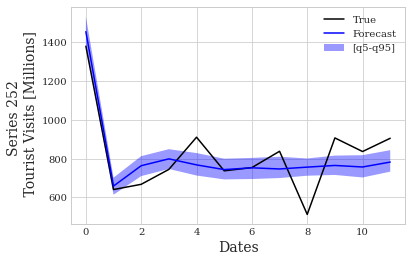

In [ ]:
region_idx  = 252  # 0 Total Australia, 252 Sidney Australia
y_plot      = Y_test[region_idx,:]
y_hat_plot  = Y_hat[region_idx,:]
yq_hat_plot = Yq_hat[region_idx,:,:]

plt.plot(y_plot, label='True', color='black')
plt.plot(y_hat_plot, label='Forecast', color='blue')
plt.fill_between(range(12),
                 y1=yq_hat_plot[:,2], 
                 y2=yq_hat_plot[:,-2],
                 facecolor='blue', alpha=0.4, label='[q5-q95]')
plt.ylabel(f'Series {region_idx} \n Tourist Visits [Millions]', fontsize=14)
plt.xlabel('Dates', fontsize=14)
plt.legend()
plt.show()

<a name="cell-3"></a>
## 3. Favorita Experiment

In [ ]:
# export
def run_favorita_arima(verbose=False):
    with CodeTimer('Read and Parse data   ', verbose):
        directory = './data/hierarchical/Favorita'
        #Favorita.preprocess_data(directory=directory,  sample_size=10, verbose=False)
        data = Favorita.load_process(directory=directory, sample_size=10, verbose=False)

        # Declare dataset dimensions
        T = 130  # 216 365 (100, 0.44) (120, 0.36) (200, 0.4)
        H = 34   # 12
        N = len(data['hier_labels'])
        
        # Declare and wrangle dataframes
        X_hier_df = data['X_hier_df']
        X_hier_df['y'] = X_hier_df['y'] + 0.001
        Y_train_df = X_hier_df.groupby(['unique_id']).tail(T+H).reset_index(drop=True)
        Y_test_df  = Y_train_df.groupby(['unique_id']).tail(H).reset_index(drop=True)
        Y_train_df = Y_train_df.groupby(['unique_id']).head(T).reset_index(drop=True)
        Y_train_df = Y_train_df[['unique_id', 'ds', 'y']]
        Y_test_df  = Y_test_df[['unique_id', 'ds', 'y']]

    with CodeTimer('Fit/Predict Model     ', verbose):
        # Fit and Predict Poisson regression            
        fcst = StatsForecast(Y_train_df.set_index('unique_id'),
                         models=[(auto_arima)], 
                         freq='D', n_jobs=1)
        Y_hat_df = fcst.forecast(H, level=LEVEL).reset_index()
        
        # Parse predictions
        Y_test = Y_test_df.y.values
        Y_hat  = Y_hat_df['auto_arima_season_length-7_mean'].values
        Yq_hat = Y_hat_df.drop(labels=['unique_id', 'ds', 
                               'auto_arima_season_length-7_mean'], axis=1).values
        
        Y_hat  = Y_hat.reshape(10, N, H)
        Y_test = Y_test.reshape(10, N, H)        
        Yq_hat = Yq_hat.reshape(10, N, H, len(QUANTILES))

        with CodeTimer('Evaluate Model        ', verbose):        
            crps_df = Favorita.get_hierarchical_crps(data=data, Y=Y_test, Y_hat=Yq_hat,
                                                     q_to_pred=QUANTILES,
                                                     model_name='SARIMAX7')

            rmse_df = Favorita.get_hierarchical_rmse(data=data, Y=Y_test, Y_hat=Y_hat,
                                                     model_name='SARIMAX7')

        print('CRPS\n', crps_df)
        print('RMSE\n', rmse_df)

        return Y_test, Y_hat, Yq_hat

In [ ]:
# export
def run_favorita_poisson_regression(verbose=False):
    with CodeTimer('Read and Parse data   ', verbose):
        directory = './data/hierarchical/Favorita'
        #Favorita.preprocess_data(directory=directory,  sample_size=10, verbose=False)
        data = Favorita.load_process(directory=directory, sample_size=10, verbose=False)

        # Declare dataset dimensions
        T = 130  # 216 365 (100, 0.44) (120, 0.36) (200, 0.4)
        H = 34   # 12
        N = len(data['hier_labels'])
        
        # Declare and wrangle dataframes
        X_hier_df = data['X_hier_df']
        X_hier_df['y'] = X_hier_df['y'] + 0.001
        Y_train_df = X_hier_df.groupby(['unique_id']).tail(T+H).reset_index(drop=True)
        Y_test_df  = Y_train_df.groupby(['unique_id']).tail(H).reset_index(drop=True)
        Y_train_df = Y_train_df.groupby(['unique_id']).head(T).reset_index(drop=True)
        X_test_df  = Y_test_df.drop(['y'], axis=1)

    with CodeTimer('Fit/Predict Model     ', verbose):
        # Fit and Predict Poisson regression            
        fcst = StatsForecast(Y_train_df.set_index('unique_id'),
                         models=[(poisson_regression)], 
                         freq='M', n_jobs=1)
        Y_hat_df = fcst.forecast(H, level=LEVEL,
                                 xreg=X_test_df.set_index('unique_id')).reset_index()
        
        # Parse predictions
        Y_test = Y_test_df.y.values
        Y_hat  = Y_hat_df['poisson_regression_mean'].values
        Yq_hat = Y_hat_df.drop(labels=['unique_id', 'ds', 
                               'poisson_regression_mean'], axis=1).values
        
        Y_hat  = Y_hat.reshape(10, N, H)
        Y_test = Y_test.reshape(10, N, H)        
        Yq_hat = Yq_hat.reshape(10, N, H, len(QUANTILES))

        with CodeTimer('Evaluate Model        ', verbose):        
            crps_df = Favorita.get_hierarchical_crps(data=data, Y=Y_test, Y_hat=Yq_hat,
                                                     q_to_pred=QUANTILES,
                                                     model_name='GLM-Poisson2')

            rmse_df = Favorita.get_hierarchical_rmse(data=data, Y=Y_test, Y_hat=Y_hat,
                                                     model_name='GLM-Poisson2')

        print('CRPS\n', crps_df)
        print('RMSE\n', rmse_df)

        return Y_test, Y_hat, Yq_hat

# Y_train_df, Y_test_df = run_favorita_poisson_regression(verbose=False)
Y_test, Y_hat, Yq_hat = run_favorita_poisson_regression(verbose=False)

CRPS
       Level  DPMN-GBU  DPMN-NBU  HierE2E  PERMBU-MinT  ARIMA-ERM  \
0   Overall    0.1975    0.2653   0.2698       0.2335     0.3675   
1  1 (geo.)    0.1365    0.2080   0.2396       0.1346     0.2979   
2  2 (geo.)    0.1892    0.2568   0.2664       0.1912     0.3593   
3  3 (geo.)    0.1994    0.2663   0.2738       0.3419     0.3729   
4  4 (geo.)    0.2649    0.3299   0.3086       0.2766     0.4408   

   ARIMA-MinT-shr  GLM-Poisson2  
0          0.2606      0.363126  
1          0.1468      0.285274  
2          0.2176      0.351560  
3          0.3769      0.361210  
4          0.3096      0.454436  
RMSE
       Level  MQCNN-NBU  DPMN-GBU  DPMN-NBU  HierE2E  ARIMA-MinT-shr  \
0   Overall        NaN       NaN       NaN      NaN             NaN   
1  1 (geo.)        NaN       NaN       NaN      NaN             NaN   
2  2 (geo.)        NaN       NaN       NaN      NaN             NaN   
3  3 (geo.)        NaN       NaN       NaN      NaN             NaN   
4  4 (geo.)        N

y_plot.shape (34,)
y_hat_plot.shape (34,)
yq_hat_plot.shape (34, 100)


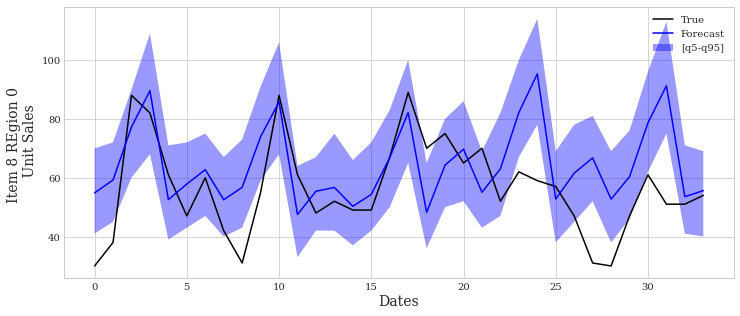

In [ ]:
item_idx    = 8
store_idx   = 0 # 32 Quito
y_plot      = Y_test[item_idx,store_idx,:]
# dates       = Y_test_df['ds'][:34].values
y_hat_plot  = Y_hat[item_idx,store_idx,:]
yq_hat_plot = Yq_hat[item_idx,store_idx,:,:]

print('y_plot.shape', y_plot.shape)
print('y_hat_plot.shape', y_hat_plot.shape)
print('yq_hat_plot.shape', yq_hat_plot.shape)

plt.figure(figsize=(12, 5))
plt.plot(y_plot, label='True', color='black')
plt.plot(y_hat_plot, label='Forecast', color='blue')
plt.fill_between(range(34), 
                 y1=yq_hat_plot[:,2], 
                 y2=yq_hat_plot[:,-2],
                 facecolor='blue', alpha=0.4, label='[q5-q95]')
plt.ylabel(f'Item {item_idx} REgion {store_idx} \n Unit Sales', fontsize=14)
plt.xlabel('Dates', fontsize=14)
plt.legend()
plt.show()